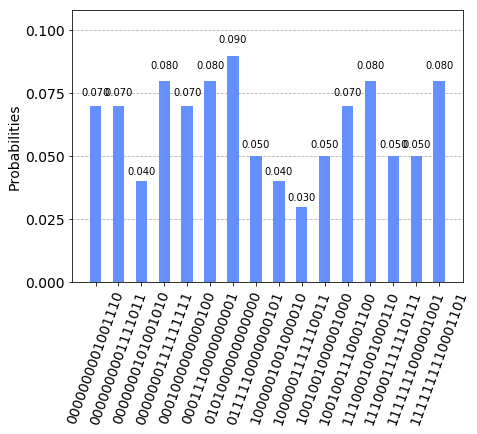

In [9]:
# (C) Copyright Renata Wong 2020.
# This is a simplified validation code for amino acid sequences of length 3
# implemented thus far: algorithm 1 that generates the conformational space
# histogram output: all 16 paths

from qiskit import *

# Attention: the following code is for sequences of length 3 bit 

length = 3

# two's complements: 
# 0 = 000, 1 = 001, 2 = 010, 3 = 011, -1 = 111, -2 = 110, -3 = 101 (-4 = 100, not needed) 
# holds the 000 coordinate for both x and y, so that x and y can start as its neighbours
# !!!! r might not be needed for the purpose of a simplified validation !!!!
r = QuantumRegister(length, 'r')
# quantum register holding the x coordinates for x0, x1, etc. (in this order) 
x = QuantumRegister(length*2, 'x')
# quantum register holding the y coordinates for y0, y1, etc. (in this order) 
y = QuantumRegister(length*2, 'y')

# quantum register holding the controls w0, w1, etc. 
w = QuantumRegister(2*(length-1), 'w')

# register holding the binary 1 (3 qubits)
a = QuantumRegister(length,'a')
# register holding the two's complement of 1 (3 qubits)
t = QuantumRegister(length,'t')
# no need to have a carry bit, use r[0] as the carry
# register holding the carry bit for ripple-carry adder
c = QuantumRegister(1,'c')

# classical register
out = ClassicalRegister(16,'out')
#out = ClassicalRegister(2*length**2+2*(length-1)+length,'out')
# quantum circuit consisting of all quantum and classical registers: 26 qubits
qc = QuantumCircuit(r,x,y,w,a,t,c,out) 

# initialisation of sequence values
#for k, i in zip(sequence, range(length)):
#    if k is '1':
#        qc.x(s[i])

# encoding binary 1
qc.x(a[length-1])
# encoding the two's complement of 1
qc.x(t[0:length])

# setting the state into superposition
qc.h(w[0:(length-1)*2])



anc = QuantumRegister(3,'anc') # ancilla qubits, at most three needed for the ccrca function
qc.add_register(anc)

# subcircuit defined for the controlled-controlled ripple-carry adder for 3 bits

sw = QuantumRegister(2,'sw')     # control qubits
sa = QuantumRegister(3,'sa')     # ancilla qubits
ss = QuantumRegister(1,'ss')     # carry 
sx = QuantumRegister(length,'sx')   # summand x (the sum is stored by overwriting the values of x)
sy = QuantumRegister(length,'sy')   # summand y
sc = QuantumCircuit(sw,sa,ss,sx,sy,name='ccrca')

sc.ccx(sw[0],sw[1],sa[0])

sc.ccx(sa[0],sy[2],sx[2])
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])

sc.ccx(sa[0],sy[1],sx[1])
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])

sc.ccx(sa[0],sy[0],sx[0])
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])

sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])
# continue
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sx[0])

sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])
# continue
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sx[1])

sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])
# continue
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sx[2])

sc.ccx(sw[0],sw[1],sa[0])

subinst = sc.to_instruction()


# global variable used in Algorithm 1 to navigate among the values of vector w
b = 0
arglist = []

# Algorithm 1: main iteration: Generating conformational space

for d in range (2, length+1):
    for q in range (0, length):
        #if d == 2:
            #qc.cx(r[q],x[(d-2)*length+q])
            #qc.cx(r[q],y[(d-2)*length+q])
        #elif d == 3:
        if d == 3:
            qc.cx(x[q],x[length+q])
            qc.cx(y[q],y[length+q])
        
        
    
    # calculating the western neighbour of site d-1 (w=11)
    arglist.append(w[b])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range((d-2)*length,(d-2)*length+3): #range [0,1,2] for d=2, range [3,4,5] for d=3
        arglist.append(x[i])
    for i in range(0,length):
        arglist.append(t[i])
    qc.append(subinst,arglist)
    
    # calculating the eastern neighbour of site d-1 (w=01)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b])
    arglist.append(w[b])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range((d-2)*length,(d-2)*length+3):
        arglist.append(x[i])
    for i in range(0, length):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    
    # calculating the northern neighbour of site d-1 (w=00)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b+1])
    arglist.append(w[b])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range((d-2)*length,(d-2)*length+3):
        arglist.append(y[i])
    for i in range(0, length):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    
    # calculating the southern neighbour of site d-1 (w=10)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b])
    arglist.append(w[b])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range((d-2)*length,(d-2)*length+3):
        arglist.append(y[i])
    for i in range(0, length):
        arglist.append(t[i])
    qc.append(subinst,arglist)
    qc.x(w[b+1])
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    b = b+2
    

coord = []
for i in range(0,2*(length-1)): #4
    coord.append(w[i])
for i in range(0,length*2): #6
    coord.append(x[i])
for i in range(0,length*2): #6
    coord.append(y[i])
qc.measure(coord,out)

# output in the form: 
# control qubits: w1 w2 (2+2 bits)
# x coordinates: x1 x2 (3+3 bits)
# y coordinates: y1 y2 (3+3 bits)
# coordinates x0 and y0 are always 0, not shown here

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc,backend = simulator, shots = 100).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)